In [ ]:
!pip install pandas
!pip install zipcodes
!pip install folium
!pip install -U pandasql

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving OVNIs_filtrado.csv to OVNIs_filtrado.csv


In [ ]:
#Importando as bibliotecas utilizadas
import pandas as pd
import zipcodes
from pandasql import sqldf
import folium

In [ ]:
#Inicializando variáveis iniciais

#O tamanho dos gráficos gerados
plt.rcParams["figure.figsize"] = [10,6]

#Inicializando o arquivo .csv como DataFrame
dataOVNIS = pd.read_csv('OVNIs_filtrado.csv')

#Função utilizada para realizar o query do DataFrame com o uso da biblioteca pandasql
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
#Essa função é usada para selecionar parte do DataFrame 
# de acordo com a Forma
def select_shape(ELEMENTS,FORMA,GROUP):
    q="""
        SELECT """+ELEMENTS+"""
        FROM dataOVNIS
        WHERE Forma = """+FORMA+""" 
        AND(Estado = 'CA'
        OR Estado = 'WA'
        OR Estado = 'FL'
        OR Estado = 'TX')
        GROUP BY """+GROUP+"""
        HAVING COUNT(*) > 9
        ORDER BY Estado asc

        LIMIT 4
      """
    return q    

In [ ]:
# QUERY TEMPORÁRIO PARA ENCONTRAR OS 4 ESTADOS COM MAIOR FREQUÊNCIA
q='''
  SELECT Estado, COUNT(*) as Relatos
  FROM dataOVNIS
  GROUP BY Estado
  HAVING COUNT(*)
  ORDER BY COUNT(*) desc
'''

# FUNÇÃO INUTILIZADA
# def select_state(ELEMENTS,CITY,GROUP):
#     q="""
#         SELECT """+ELEMENTS+"""
#         FROM dataOVNIS
#         WHERE Estado = """+CITY+"""
#         GROUP BY """+GROUP+"""
#         HAVING COUNT(*) > 9
#         ORDER BY COUNT(*) desc
#       """
#     return q

consulta = pandasql.sqldf(q, locals())
consulta.head(4)

,Estado,Relatos
0,CA,11527
1,FL,5655
2,WA,4956
3,TX,4172


In [ ]:
#DEPRECATED
#Para encontrar a quantidade de relatos totais em cada estado || irrelevante para o trabalho final
query1 = pysqldf(select_state('Estado, COUNT(*) as Relatos, Forma',"""'CA'""",'Estado'))
query2 = pysqldf(select_state('Estado, COUNT(*) as Relatos, Forma',"""'FL'""",'Estado'))
query3 = pysqldf(select_state('Estado, COUNT(*) as Relatos, Forma',"""'WA'""",'Estado'))
query4 = pysqldf(select_state('Estado, COUNT(*) as Relatos, Forma',"""'TX'""",'Estado'))

estadosCOUNT = pd.concat([query1,query2,query3,query4], ignore_index=True)
estadosCOUNT

,Estado,Relatos,Forma
0,CA,11527,Cigar
1,FL,5655,Light
2,WA,4956,Chevron
3,TX,4172,Rectangle


In [ ]:
#Para encontrar a contagem de formas em cada estado
query5 = pysqldf(select_shape('COUNT(*)',"""'Light'""",'Estado'))
query6 = pysqldf(select_shape('COUNT(*)',"""'Circle'""",'Estado'))
query7 = pysqldf(select_shape('COUNT(*)',"""'Fireball'""",'Estado'))
query8 = pysqldf(select_shape('COUNT(*)',"""'Triangle'""",'Estado'))

#Ordem das linhas do dataFrame, ['CA','FL','TX','WA'])
#Ordem das colunas do dataFrame, ['Light','Circle','Fireball','Triangle'])
estadosFORMA = pd.concat([query5,query6,query7,query8], ignore_index=True,axis=1)
estadosFORMA

,0,1,2,3
0,2474,1193,1000,987
1,1088,652,630,476
2,861,390,262,433
3,1146,477,465,404


In [ ]:
#Tratamento para gerar um gráfico em barras
estados = ['CA','FL','TX','WA']
light = estadosFORMA[0].tolist()
circle = estadosFORMA[1].tolist()
fireball = estadosFORMA[2].tolist()
triangle = estadosFORMA[3].tolist()

#Um novo DataFrame é criado dessa vez com os estados e tipos de forma
# explicitados para facilitar a criação dos mapas,
# não seria possível com o shape de índices e labels prévio
plotOVNIS = pd.DataFrame({
    'light': light,
    'circle': circle,
    'fireball': fireball,
    'triangle': triangle}, index=estados)

plotOVNIS

,light,circle,fireball,triangle
CA,2474,1193,1000,987
FL,1088,652,630,476
TX,861,390,262,433
WA,1146,477,465,404


#Plotando os mapas

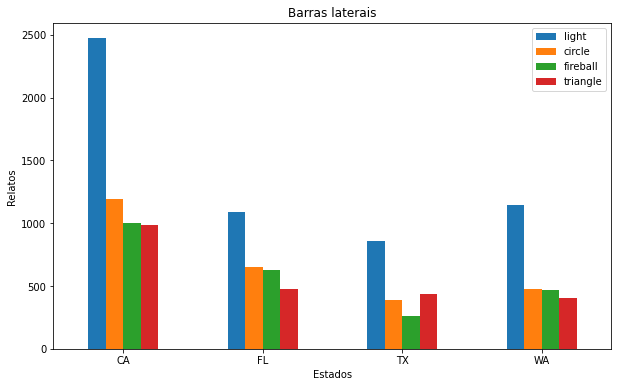

In [ ]:
#Mapa em barras laterais,criado usando a função .plot própria do pandas
ax = plotOVNIS.plot.bar(rot=0, xlabel='Estados', ylabel='Relatos', title='Barras laterais'
, legend='Shape')

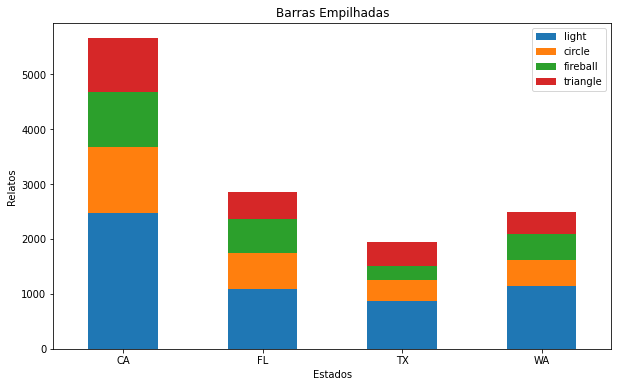

In [ ]:
#Mapas em barras empilhadas, também usando a função do pandas
ax1 = plotOVNIS.plot.bar(rot=0, xlabel='Estados', ylabel='Relatos', title='Barras Empilhadas'
, legend='Shape', stacked=True)

MAPAS

MAPAS

In [ ]:
# Coordenadas geográficas dos estados "CA, FL, TX, WA"

CAlatitude = 36.778259
CAlongitude = -119.417931

FLlatitude = 25.761681
FLlongitude = -80.191788

TXlatitude = 29.749907
TXlongitude = -95.358421

WAlatitude = 47.751076
WAlongitude = -120.740135

# Mapa de cada um dos Estados "CA, FL, TX, WA"
CAmapa = folium.Map(location=[CAlatitude, CAlongitude])
FLmapa = folium.Map(location=[FLlatitude, FLlongitude])
TXmapa = folium.Map(location=[TXlatitude, TXlongitude])
WAmapa = folium.Map(location=[WAlatitude, WAlongitude])

#Testar mapas
CAmapa
FLmapa
TXmapa
WAmapa

In [ ]:
# Criação de DataFrame com o conteúdo da biblioteca zipcodes
zipcodes_j = zipcodes.list_all()
df_zipcodes = pd.DataFrame(zipcodes_j)
df_zipcodes.head()

,zip_code,zip_code_type,active,city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,lat,long
0,00501,UNIQUE,True,Holtsville,[],[I R S Service Center],NY,Suffolk County,America/New_York,[631],NA,US,40.8179,-73.0453
1,00544,UNIQUE,True,Holtsville,[],[Irs Service Center],NY,Suffolk County,America/New_York,[631],NA,US,40.7888,-73.0394
2,00601,STANDARD,True,Adjuntas,[],"[Colinas Del Gigante, Jard De Adjuntas, Urb Sa...",PR,Adjuntas Municipio,America/Puerto_Rico,"[787, 939]",NA,US,18.1967,-66.7367
3,00602,STANDARD,True,Aguada,[],"[Alts De Aguada, Bo Guaniquilla, Comunidad Las...",PR,Aguada Municipio,America/Puerto_Rico,"[787, 939]",NA,US,18.3529,-67.1775
4,00603,STANDARD,True,Aguadilla,[Ramey],"[Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceib...",PR,Aguadilla Municipio,America/Puerto_Rico,[787],NA,US,18.4586,-67.1299


In [ ]:
# Filtro das colunas "zip_code", "city", "state", "lat", "long" do df_zipcodes
df_zipcodes = df_zipcodes[['zip_code','city','state','lat','long']]

# Redefinição do nome das colunas
df_zipcodes.columns = ['zip_code','Cidade','Estado','Lat','Long']
df_zipcodes

,zip_code,Cidade,Estado,Lat,Long
0,00501,Holtsville,NY,40.8179,-73.0453
1,00544,Holtsville,NY,40.7888,-73.0394
2,00601,Adjuntas,PR,18.1967,-66.7367
3,00602,Aguada,PR,18.3529,-67.1775
4,00603,Aguadilla,PR,18.4586,-67.1299
...,...,...,...,...,...
42627,99926,Metlakatla,AK,55.1450,-131.5439
42628,99927,Point Baker,AK,56.1513,-133.3490
42629,99928,Ward Cove,AK,55.4104,-131.7237
42630,99929,Wrangell,AK,56.1800,-132.0304


In [ ]:
# Remoção de dados duplicados nas colunas "city" e "state"
df_zipcodes.drop_duplicates(subset=['Cidade','Estado'],inplace=True)
df_zipcodes

,zip_code,Cidade,Estado,Lat,Long
0,00501,Holtsville,NY,40.8179,-73.0453
2,00601,Adjuntas,PR,18.1967,-66.7367
3,00602,Aguada,PR,18.3529,-67.1775
4,00603,Aguadilla,PR,18.4586,-67.1299
7,00606,Maricao,PR,18.1667,-66.9392
...,...,...,...,...,...
42626,99925,Klawock,AK,55.5498,-132.9676
42627,99926,Metlakatla,AK,55.1450,-131.5439
42628,99927,Point Baker,AK,56.1513,-133.3490
42629,99928,Ward Cove,AK,55.4104,-131.7237


In [ ]:
# Filtro de Estados com mais visualização de OVNIS no DataFrame 'dataOVNIS'

q='''
  SELECT Estado, Cidade, COUNT(*) as Relatos
  FROM dataOVNIS
  GROUP BY Estado, Cidade
  ORDER BY Relatos desc
'''

df_filtro = pandasql.sqldf(q, locals())

# Criando arquivo .csv ['df_filtro'] com o diltro da query 
df_filtro.to_csv('df_filtro_mapa.csv', index=False)
df_filtro

,Estado,Cidade,Relatos
0,AZ,Phoenix,556
1,WA,Seattle,553
2,NV,Las Vegas,470
3,OR,Portland,431
4,CA,San Diego,399
...,...,...,...
21398,WY,"Wyoming (I-80, westbound)",1
21399,WY,Wyoming (rural; central),1
21400,WY,Yellowstone,1
21401,WY,Yellowstone North Entrance,1


Cruzamento de DataFrames "df_zicodes" e "df_filtro"

In [ ]:
df_coordenadas = df_filtro.merge(df_zipcodes, on=['Estado', 'Cidade'])

# Gerar arquivo .csv ['df_coordenadas'] com o cruzamento dos DataFrames 
df_coordenadas.to_csv('OVNIS_coordenadas.csv')
df_coordenadas

,Estado,Cidade,Relatos,zip_code,Lat,Long
0,AZ,Phoenix,556,85001,33.4486,-112.0733
1,WA,Seattle,553,98101,47.6110,-122.3335
2,NV,Las Vegas,470,89101,36.1736,-115.1264
3,OR,Portland,431,97201,45.5074,-122.6898
4,CA,San Diego,399,92101,32.7199,-117.1805
...,...,...,...,...,...,...
12285,WY,Opal,1,83124,41.7683,-110.2402
12286,WY,Recluse,1,82725,44.8203,-105.7762
12287,WY,Rozet,1,82727,44.1855,-105.2337
12288,WY,Saratoga,1,82331,41.4684,-106.7911


Extração de dados para criação do MAPA do EUA

In [ ]:
from folium import plugins 

In [ ]:
coordenadas = pd.read_csv('OVNIS_coordenadas.csv')

# Definição de Latitude e Longitude
Lat = coordenadas.Lat
Long = coordenadas.Long

In [ ]:
# Mapeação de calor do EUA

EUA_Mapa = folium.Map(
    location = [37.8427887, -98.3807258],
    zoom_start=4
)

EUA_Mapa.add_child(plugins.HeatMap(list(zip(Lat, Long)), radius=13))  

EUA_Mapa

In [ ]:
# Fonte: https://minerandodados.com.br/plotando-mapas-interativos-com-python-visualize-dados-de-vendas-por-regiao/

Extração de dados para criação do MAPA da CALIFÓRNIA

In [ ]:
coordenadas_CA = pd.read_csv('OVNIS_coordenadas.csv')

q='''
  SELECT *
  FROM coordenadas_CA
  WHERE Estado = 'CA'
'''

filtro_CA = pandasql.sqldf(q, locals())

# DataFrame ['df_california'] com o filtro da query 
df_california = pd.DataFrame(filtro_CA)
df_california

,Unnamed: 0,Estado,Cidade,Relatos,zip_code,Lat,Long
0,4,CA,San Diego,399,92101,32.7199,-117.1805
1,5,CA,Los Angeles,385,90001,33.9736,-118.2479
2,15,CA,Sacramento,243,94203,38.5819,-121.4935
3,16,CA,San Jose,225,95101,37.3435,-121.8887
4,18,CA,San Francisco,199,94101,37.7700,-122.4100
...,...,...,...,...,...,...,...
802,8095,CA,Wheatland,1,95692,39.0510,-121.3977
803,8096,CA,Wilton,1,95693,38.3988,-121.2547
804,8097,CA,Winterhaven,1,92283,33.0549,-115.0698
805,8098,CA,Wofford Heights,1,93285,35.6173,-118.6098


In [ ]:
# Definição de Latitude e Longitude do mapa da Califórnia
CALat = df_california.Lat
CALong = df_california.Long

In [ ]:
# Mapeação de Calor da Califórnia

CA_Mapa = folium.Map(
    location = [36.778259, -119.417931],
    zoom_start=5.5
)

CA_Mapa.add_child(plugins.HeatMap(list(zip(CALat, CALong)), radius=13).add_to(CA_Mapa))

CA_Mapa

In [ ]:
# A cidade com mais avistamentos de OVNIS na Califórnia e por quê.

'''
  Esta cidade é San Diego.

'''


'\n  Esta cidade é San Diego.\n\n'